In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from functions import *
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.spatial import ConvexHull

In [2]:
bc_counts, fitness_df, grants_df_with_barcode_df, full_df = create_full_fitness_dataframe()

# all Li mutants from WT 
li_wt_mutants = bc_counts[(bc_counts['source_publication'] == 'Li2019') & (bc_counts['ancestor'] == 'WT')]['barcode']
# # first, mask all values of -10 with extinct_fitness
fitness_df = fitness_df.applymap(replace_extinct)

all_conds = twoday_conds + oneday_conds + salt_conds
perts=[]

base_conditions = ['M3', '1.5' ,'30', 'M3b4']

for batch,conditions in batches.items():
    for home_condition,perturbations in conditions.items():
        for perturbation in perturbations:
            if f'{batch}_{home_condition}_{perturbation}_fitness' in fitness_df.columns:
                perts.append(perturbation)

# get set of perts
perts = list(set(perts))


# for each condition, in a new dataframe, subtract out the home average 
local_perturbation_df = fitness_df[twoday_conds+oneday_conds+salt_conds].copy()
for home_env in environment_dict.keys():
    base_conds = [cond for cond in environment_dict[home_env] if 'M3' in cond or '1.5_' in cond or '30_' in cond or 'M3b4_' in cond]
    for env in environment_dict[home_env]:
        batch = env.split('_')[0]
        relevant_home=[col for col in fitness_df.columns if home_env in col and batch in col and col in base_conds]
        if len(relevant_home) >0:
            local_perturbation_df[env] = fitness_df[env] - fitness_df[relevant_home[0]]
        else:
            print(f'No relevant home condition for {env}')
            local_perturbation_df[env] = np.nan

organized_local_perturbation_fitness_df = pd.DataFrame(index = local_perturbation_df.index)
for pert in perts:
    cols = [col for col in local_perturbation_df.columns if f'{pert}_' in col]
    organized_local_perturbation_fitness_df[cols] = local_perturbation_df[cols]

organized_local_perturbation_fitness_df = organized_local_perturbation_fitness_df.dropna(axis=1)


No relevant home condition for Batch4_Salt_4uMH89_fitness
No relevant home condition for Batch4_Salt_10uMParomomycin_fitness
No relevant home condition for Batch4_Salt_50uMParomomycin_fitness
No relevant home condition for Batch4_Salt_0.5%EtOH_fitness


In [3]:
fitness_df.columns

Index(['Batch1_1Day_28-R1_fitness', 'Batch1_1Day_28-R1_stderror',
       'Batch1_1Day_28-R2_fitness', 'Batch1_1Day_28-R2_stderror',
       'Batch1_1Day_30-R1_fitness', 'Batch1_1Day_30-R1_stderror',
       'Batch1_1Day_30-R2_fitness', 'Batch1_1Day_30-R2_stderror',
       'Batch1_1Day_30Baffle-R1_fitness', 'Batch1_1Day_30Baffle-R1_stderror',
       ...
       'Batch2_Salt_1.8Baffle_stderror', 'Batch4_1Day_M3b4_fitness',
       'Batch4_1Day_M3b4_stderror', 'Batch4_1Day_0.5%EtOH_fitness',
       'Batch4_1Day_0.5%EtOH_stderror', 'Batch4_2Day_M3b4_fitness',
       'Batch4_2Day_M3b4_stderror', 'Batch1_1Day_30_fitness',
       'Batch1_1Day_30_stderror', 'barcode'],
      dtype='object', length=349)

found 1.5 in base conditions
found M3 in base conditions
found M3b4 in base conditions
Base condition perturbations: [2, 5, 11, 18, 23, 26, 32, 39, 45, 48]


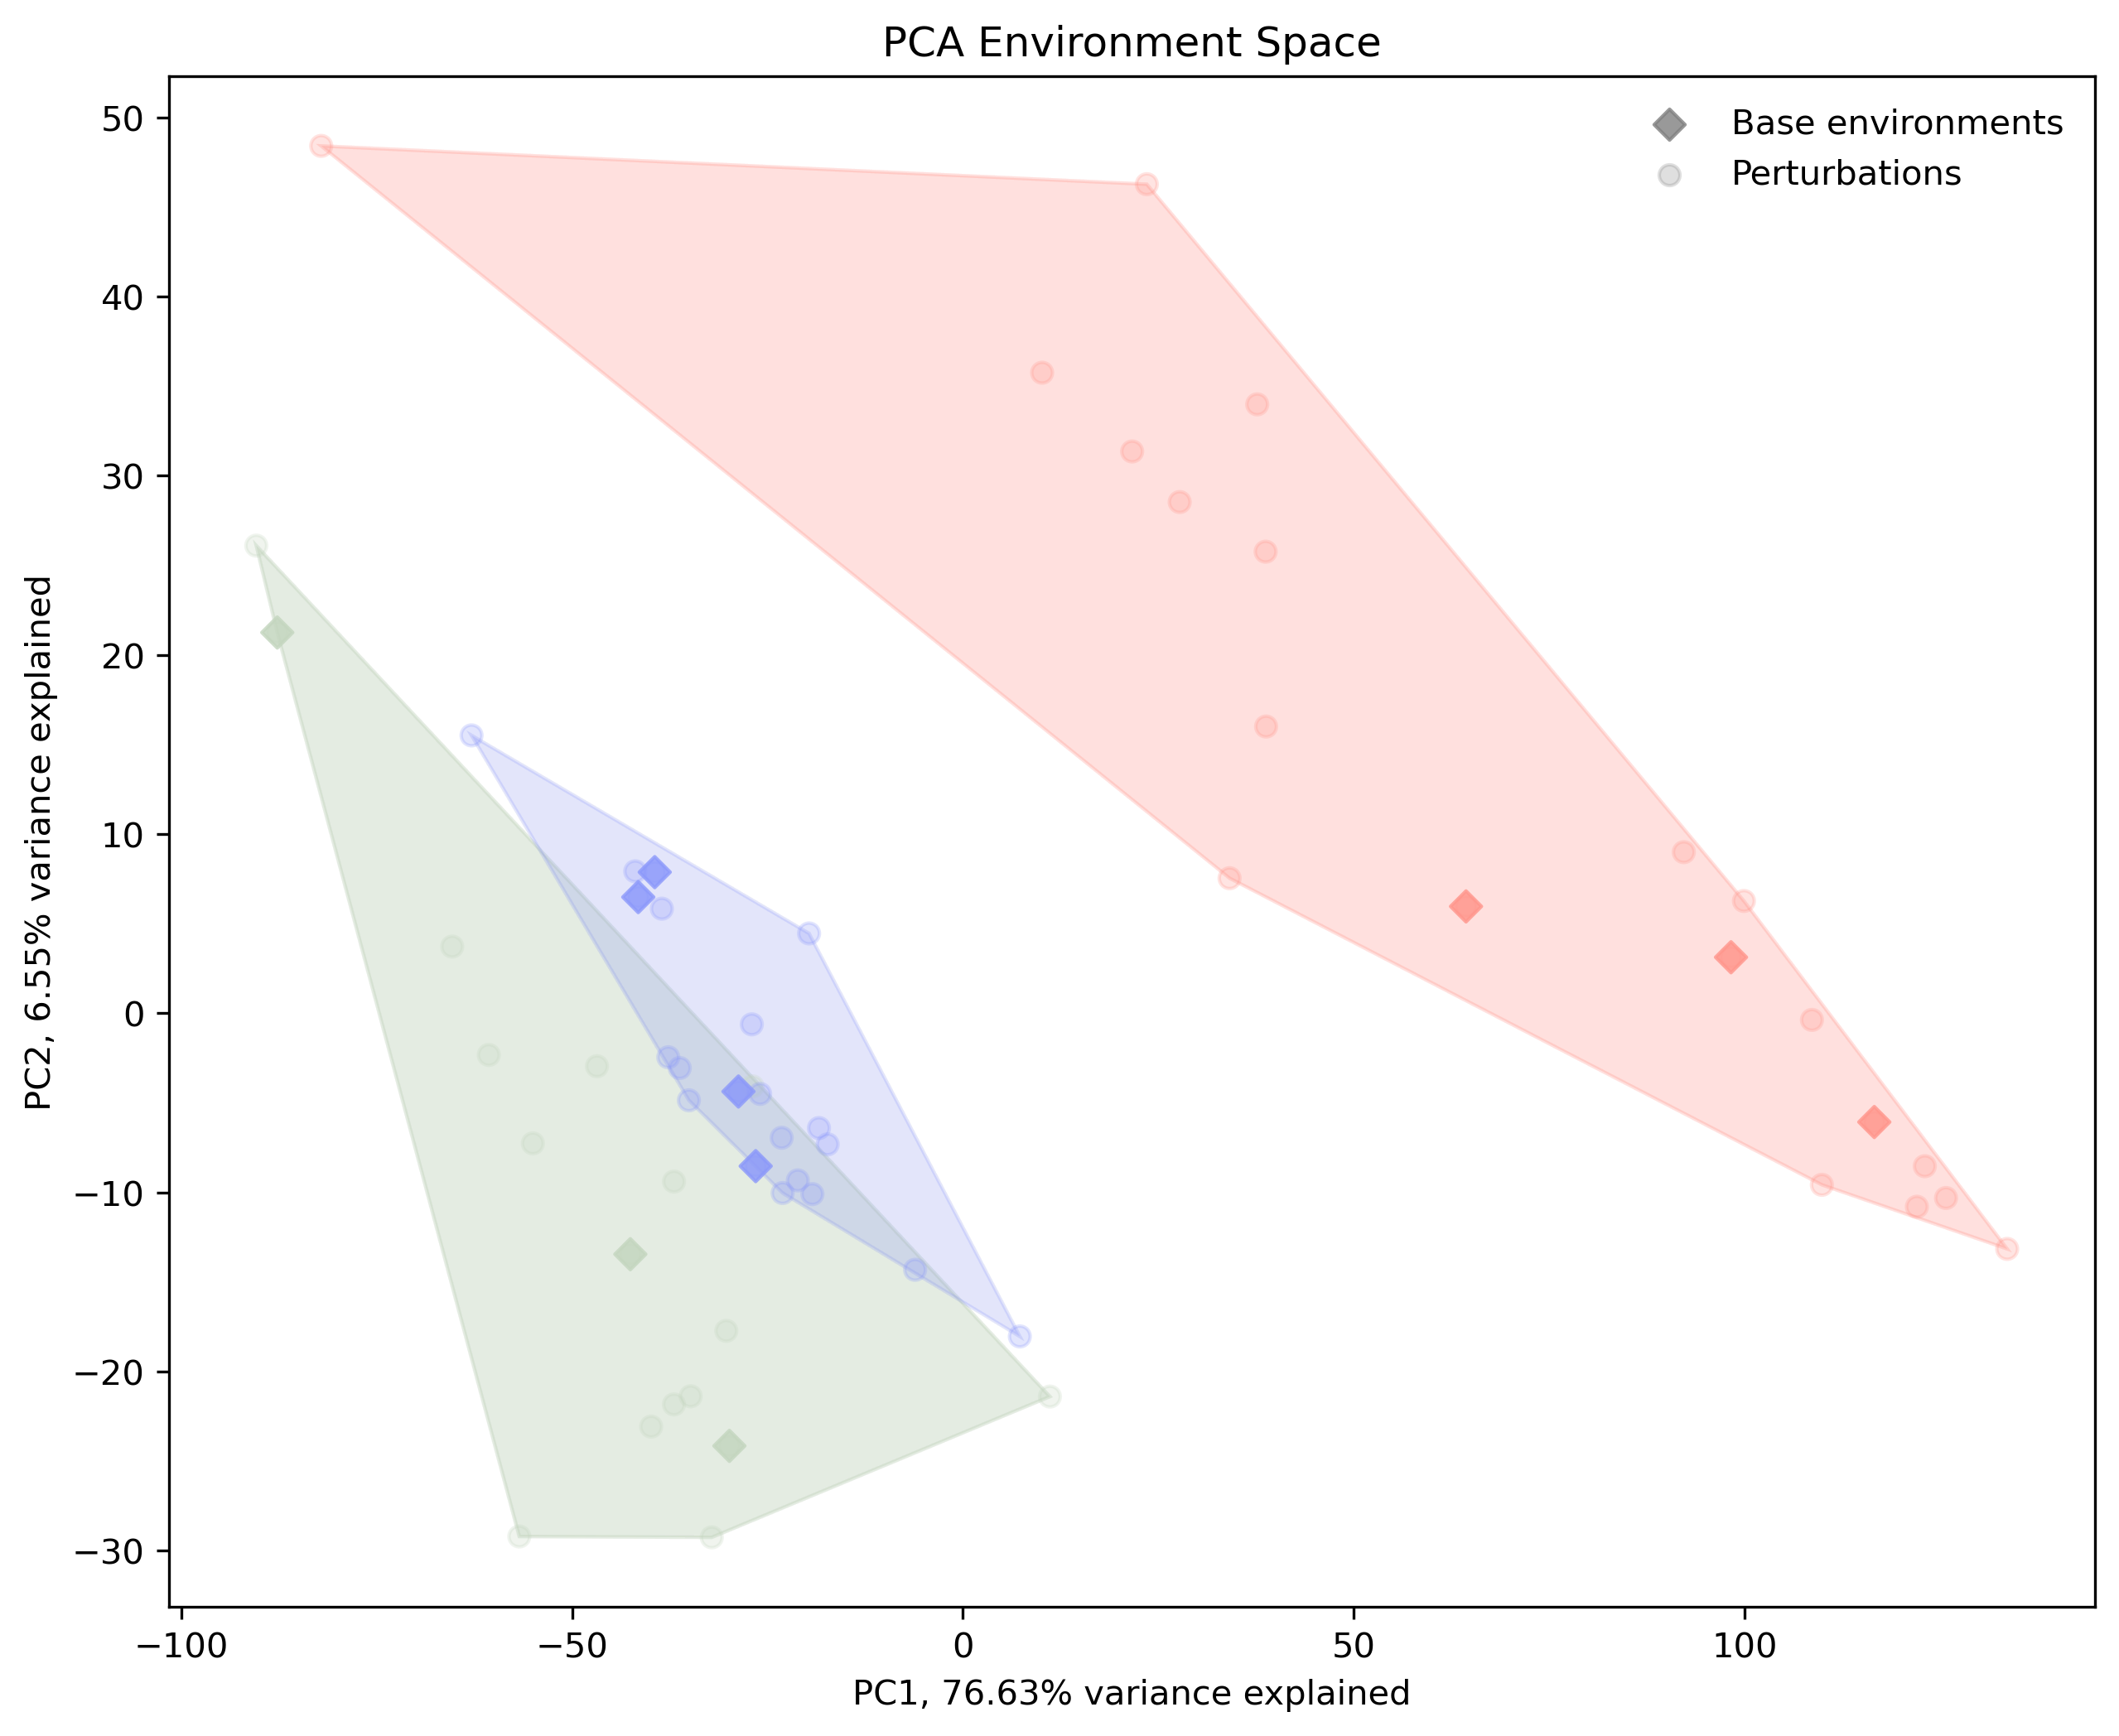

In [7]:
env_color_dict = {'2Day': (0.77, 0.84, 0.75), '1Day': (0.55, 0.6, 0.98), 'Salt': (1, 0.59, 0.55)}
# do pca on fitness_df
X = fitness_df[all_conds].values.T
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X)

# color by base condition 
base_cond_pert = []
colors =[]
base_colors = []
for i,cond in enumerate(all_conds):
    pert = cond.split('_')[2]
    if '2Day' in cond:
        colors.append(env_color_dict['2Day'])
        if pert in base_conditions:
            base_cond_pert.append(i)
            base_colors.append(env_color_dict['2Day'])
            print(f'found {pert} in base conditions')
    elif '1Day' in cond:
        colors.append(env_color_dict['1Day'])
        if pert in base_conditions:
            base_cond_pert.append(i)
            base_colors.append(env_color_dict['1Day'])
    elif 'Salt' in cond:
        colors.append(env_color_dict['Salt'])
        if pert in base_conditions:
            base_cond_pert.append(i)
            base_colors.append(env_color_dict['Salt'])
    else:
        colors.append('black')

print(f'Base condition perturbations: {base_cond_pert}')

# plot pca
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
# add convex hulls around points corresponding to twoday_conds, oneday_conds, and salt_conds 
twoday_points = pca.transform(X)[[all_conds.index(cond) for cond in twoday_conds]]
oneday_points = pca.transform(X)[[all_conds.index(cond) for cond in oneday_conds]]
salt_points = pca.transform(X)[[all_conds.index(cond) for cond in salt_conds]]

twoday_hull = ConvexHull(twoday_points)
oneday_hull = ConvexHull(oneday_points)
salt_hull = ConvexHull(salt_points)

for simplex in twoday_hull.simplices:
    # plt.plot(twoday_points[simplex, 0], twoday_points[simplex, 1], env_color_dict['2Day'], alpha=0.5)
    # fill in the convex hulls
    plt.fill(twoday_points[twoday_hull.vertices,0], twoday_points[twoday_hull.vertices,1], color = (0.77, 0.84, 0.75), alpha=0.1)
for simplex in oneday_hull.simplices:
    # plt.plot(oneday_points[simplex, 0], oneday_points[simplex, 1], env_color_dict['1Day'], alpha=0.5)
    plt.fill(oneday_points[oneday_hull.vertices,0], oneday_points[oneday_hull.vertices,1], color = (0.55, 0.6, 0.98), alpha=0.05)
for simplex in salt_hull.simplices:
    # plt.plot(salt_points[simplex, 0], salt_points[simplex, 1], env_color_dict['Salt'], alpha=0.5)
    plt.fill(salt_points[salt_hull.vertices,0], salt_points[salt_hull.vertices,1], color = ( 1, 0.59,0.55), alpha=0.05)



ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], color=colors, alpha=0.25, marker='o')
ax.scatter(pca.transform(X)[np.array(base_cond_pert),0], pca.transform(X)[np.array(base_cond_pert),1], marker='D',s = 40, color=base_colors, alpha = 0.8)
ax.set_xlabel(f'PC1, {round(pca.explained_variance_ratio_[0]*100,2)}% variance explained')
ax.set_ylabel(f'PC2, {round(pca.explained_variance_ratio_[1]*100,2)}% variance explained')
ax.set_title('PCA Environment Space')


# legend 
ax.scatter([],[], color='gray', marker = 'D', s=40, alpha =0.8,label='Base environments')
ax.scatter([],[], color='gray', alpha = 0.25,label='Perturbations')
# ax.scatter([],[], color=env_color_dict['1Day'], label='1Day')
# ax.scatter([],[], color=env_color_dict['Salt'], label='Salt')
#no box around legend
ax.legend(frameon=False)
# ax.legend()

plt.savefig(f'../plots/pca_environment_space_April2025.png')
    



[0.65603835 0.05825639]


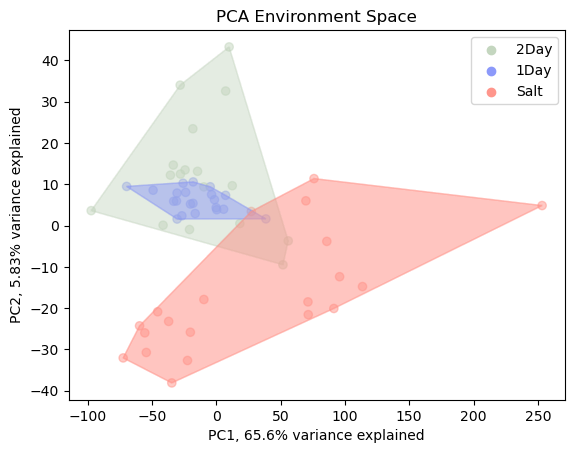

In [6]:
# do PCA on the local perturbation dataframe
env_color_dict = {'2Day': (0.77, 0.84, 0.75), '1Day': (0.55, 0.6, 0.98), 'Salt': (1, 0.59, 0.55)}
# do pca on fitness_df
from functions import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
env_color_dict = {'2Day': (0.77, 0.84, 0.75), '1Day': (0.55, 0.6, 0.98), 'Salt': (1, 0.59, 0.55)}

X = organized_perturbation_fitness_df[all_conds].values.T
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X)

# color by base condition 
colors =[]
for cond in all_conds:
    if '2Day' in cond:
        colors.append(env_color_dict['2Day'])
    elif '1Day' in cond:
        colors.append(env_color_dict['1Day'])
    elif 'Salt' in cond:
        colors.append(env_color_dict['Salt'])
    else:
        colors.append('black')


# plot pca
fig, ax = plt.subplots()
ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], color=colors, alpha=0.5)
# how much variance is explained by the first two components?
print(pca.explained_variance_ratio_)
ax.set_xlabel(f'PC1, {round(pca.explained_variance_ratio_[0]*100,2)}% variance explained')
ax.set_ylabel(f'PC2, {round(pca.explained_variance_ratio_[1]*100,2)}% variance explained')
ax.set_title('PCA Environment Space')
# add convex hulls around points corresponding to twoday_conds, oneday_conds, and salt_conds 
twoday_points = pca.transform(X)[[all_conds.index(cond) for cond in twoday_conds]]
oneday_points = pca.transform(X)[[all_conds.index(cond) for cond in oneday_conds]]
salt_points = pca.transform(X)[[all_conds.index(cond) for cond in salt_conds]]

twoday_hull = ConvexHull(twoday_points)
oneday_hull = ConvexHull(oneday_points)
salt_hull = ConvexHull(salt_points)

for simplex in twoday_hull.simplices:
    # plt.plot(twoday_points[simplex, 0], twoday_points[simplex, 1], env_color_dict['2Day'], alpha=0.5)
    # fill in the convex hulls
    plt.fill(twoday_points[twoday_hull.vertices,0], twoday_points[twoday_hull.vertices,1], color = (0.77, 0.84, 0.75), alpha=0.1)
for simplex in oneday_hull.simplices:
    # plt.plot(oneday_points[simplex, 0], oneday_points[simplex, 1], env_color_dict['1Day'], alpha=0.5)
    plt.fill(oneday_points[oneday_hull.vertices,0], oneday_points[oneday_hull.vertices,1], color = (0.55, 0.6, 0.98), alpha=0.1)
for simplex in salt_hull.simplices:
    # plt.plot(salt_points[simplex, 0], salt_points[simplex, 1], env_color_dict['Salt'], alpha=0.5)
    plt.fill(salt_points[salt_hull.vertices,0], salt_points[salt_hull.vertices,1], color = ( 1, 0.59,0.55), alpha=0.1)

# legend 
ax.scatter([],[], color=env_color_dict['2Day'], label='2Day')
ax.scatter([],[], color=env_color_dict['1Day'], label='1Day')
ax.scatter([],[], color=env_color_dict['Salt'], label='Salt')
ax.legend()

plt.show()



[0.64608099 0.07235708]


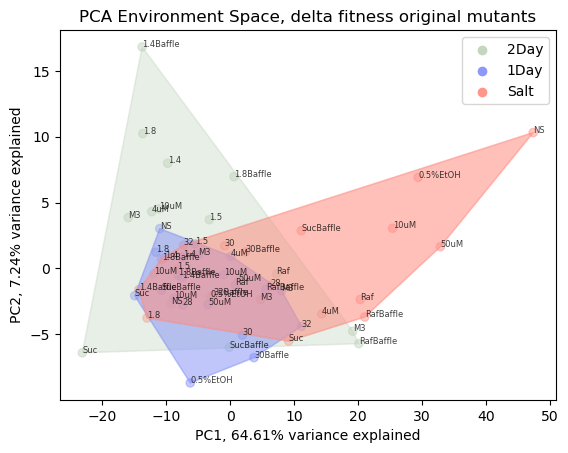

In [12]:
# do PCA on the local perturbation dataframe with just original mutants 

X = organized_perturbation_fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'],all_conds].values.T
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X)

# color by base condition 
colors =[]
for cond in all_conds:
    if '2Day' in cond:
        colors.append(env_color_dict['2Day'])
    elif '1Day' in cond:
        colors.append(env_color_dict['1Day'])
    elif 'Salt' in cond:
        colors.append(env_color_dict['Salt'])
    else:
        colors.append('black')


# plot pca
fig, ax = plt.subplots()
ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], color=colors, alpha=0.5)
#label each condiiton on the plot 
for i, txt in enumerate(all_conds):
    pert = txt.split('_')[2]
    ax.annotate(pert, (pca.transform(X)[i,0], pca.transform(X)[i,1]), fontsize=6, alpha=0.75)

    
# how much variance is explained by the first two components?
print(pca.explained_variance_ratio_)
ax.set_xlabel(f'PC1, {round(pca.explained_variance_ratio_[0]*100,2)}% variance explained')
ax.set_ylabel(f'PC2, {round(pca.explained_variance_ratio_[1]*100,2)}% variance explained')
ax.set_title('PCA Environment Space, delta fitness original mutants')
# add convex hulls around points corresponding to twoday_conds, oneday_conds, and salt_conds 
twoday_points = pca.transform(X)[[all_conds.index(cond) for cond in twoday_conds]]
oneday_points = pca.transform(X)[[all_conds.index(cond) for cond in oneday_conds]]
salt_points = pca.transform(X)[[all_conds.index(cond) for cond in salt_conds]]

twoday_hull = ConvexHull(twoday_points)
oneday_hull = ConvexHull(oneday_points)
salt_hull = ConvexHull(salt_points)

for simplex in twoday_hull.simplices:
    # plt.plot(twoday_points[simplex, 0], twoday_points[simplex, 1], env_color_dict['2Day'], alpha=0.5)
    # fill in the convex hulls
    plt.fill(twoday_points[twoday_hull.vertices,0], twoday_points[twoday_hull.vertices,1], color = (0.77, 0.84, 0.75), alpha=0.1)
for simplex in oneday_hull.simplices:
    # plt.plot(oneday_points[simplex, 0], oneday_points[simplex, 1], env_color_dict['1Day'], alpha=0.5)
    plt.fill(oneday_points[oneday_hull.vertices,0], oneday_points[oneday_hull.vertices,1], color = (0.55, 0.6, 0.98), alpha=0.1)
for simplex in salt_hull.simplices:
    # plt.plot(salt_points[simplex, 0], salt_points[simplex, 1], env_color_dict['Salt'], alpha=0.5)
    plt.fill(salt_points[salt_hull.vertices,0], salt_points[salt_hull.vertices,1], color = ( 1, 0.59,0.55), alpha=0.1)

# legend 
ax.scatter([],[], color=env_color_dict['2Day'], label='2Day')
ax.scatter([],[], color=env_color_dict['1Day'], label='1Day')
ax.scatter([],[], color=env_color_dict['Salt'], label='Salt')
ax.legend()

plt.show()



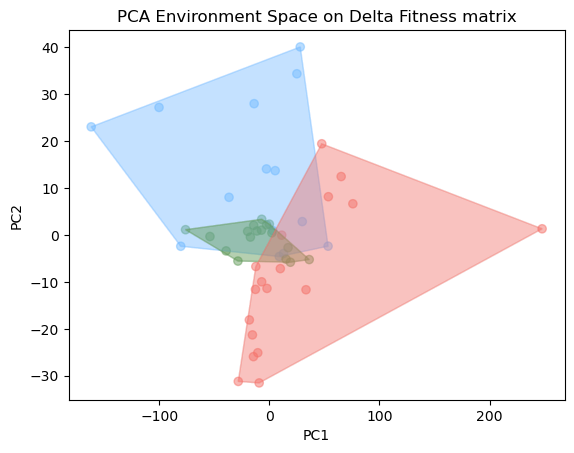

In [32]:
# do pca on fitness_df'1D_loo_mse_df.csv
all_base_conds = []
for home_env in environment_dict.keys():
    base_conds = [cond for cond in environment_dict[home_env] if 'M3' in cond or '1.5_' in cond or '30_' in cond]
    all_base_conds.extend(base_conds)

these_conds = [cond for cond in all_conds if cond not in all_base_conds]
X = organized_local_perturbation_fitness_df[these_conds].values.T

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X)

# color by base condition 
colors =[]
for cond in these_conds:
    if '2Day' in cond:
        colors.append(env_color_dict['2Day'])
    elif '1Day' in cond:
        colors.append(env_color_dict['1Day'])
    elif 'Salt' in cond:
        colors.append(env_color_dict['Salt'])
    else:
        colors.append('black')


# plot pca
fig, ax = plt.subplots()
ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], color=colors, alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Environment Space on Delta Fitness matrix')

twoday_points = pca.transform(X)[[these_conds.index(cond) for cond in twoday_conds if cond in these_conds]]
oneday_points = pca.transform(X)[[these_conds.index(cond) for cond in oneday_conds if cond in these_conds]]
salt_points = pca.transform(X)[[these_conds.index(cond) for cond in salt_conds if cond in these_conds]]

twoday_hull = ConvexHull(twoday_points)
oneday_hull = ConvexHull(oneday_points)
salt_hull = ConvexHull(salt_points)

for simplex in twoday_hull.simplices:
    # plt.plot(twoday_points[simplex, 0], twoday_points[simplex, 1], env_color_dict['2Day'], alpha=0.5)
    # fill in the convex hulls
    plt.fill(twoday_points[twoday_hull.vertices,0], twoday_points[twoday_hull.vertices,1], color = env_color_dict['2Day'], alpha=0.1)
for simplex in oneday_hull.simplices:
    # plt.plot(oneday_points[simplex, 0], oneday_points[simplex, 1], env_color_dict['1Day'], alpha=0.5)
    plt.fill(oneday_points[oneday_hull.vertices,0], oneday_points[oneday_hull.vertices,1], color = env_color_dict['1Day'], alpha=0.1)
for simplex in salt_hull.simplices:
    # plt.plot(salt_points[simplex, 0], salt_points[simplex, 1], env_color_dict['Salt'], alpha=0.5)
    plt.fill(salt_points[salt_hull.vertices,0], salt_points[salt_hull.vertices,1], color = env_color_dict['Salt'], alpha=0.1)

plt.show()
    


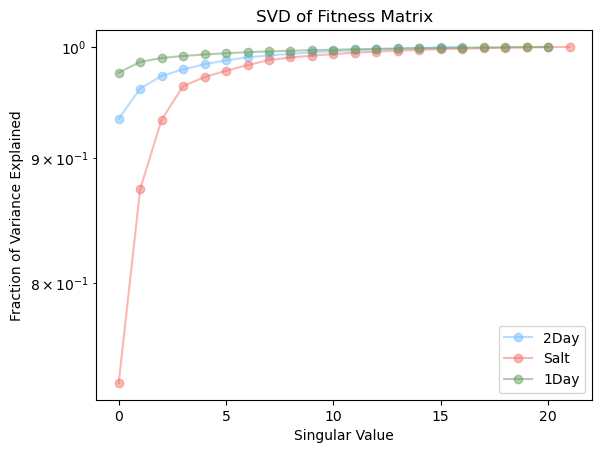

In [37]:
# do SVD on fitness_df
for base in environment_dict.keys():
    X = fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], environment_dict[base]].values
    U, S, V = np.linalg.svd(X, full_matrices=False)
    plt.semilogy(np.cumsum(S**2/np.sum(S**2)), 'o-', color = env_color_dict[base], label = base, alpha=0.5)
plt.xlabel('Singular Value')
plt.ylabel('Fraction of Variance Explained')
plt.title('SVD of Fitness Matrix')
plt.legend()

[0.06584608 0.03863579 0.02702988 0.02104553 0.01624816 0.01262244
 0.00977225 0.00807103 0.00652773 0.00521848 0.00405364 0.00317197
 0.00240033 0.00169595 0.00104911 0.00047988 0.        ]
[2.72413532e-01 1.26035660e-01 6.65476902e-02 3.64230925e-02
 2.81120778e-02 2.23849129e-02 1.70597098e-02 1.23610586e-02
 9.92605500e-03 8.28086783e-03 6.74211849e-03 5.41058668e-03
 4.41842778e-03 3.56687509e-03 2.83523483e-03 2.14605471e-03
 1.59606407e-03 1.17285855e-03 8.05052972e-04 4.68307332e-04
 2.00088962e-04 2.22044605e-16]
[2.40838240e-02 1.40467665e-02 1.04218110e-02 8.55124779e-03
 7.09421320e-03 5.94680195e-03 5.00500457e-03 4.23822040e-03
 3.63888542e-03 3.09359908e-03 2.57353490e-03 2.18303585e-03
 1.80352793e-03 1.47713088e-03 1.20033792e-03 9.46996332e-04
 7.13146781e-04 5.00054180e-04 2.95478146e-04 1.22790866e-04
 1.11022302e-16]


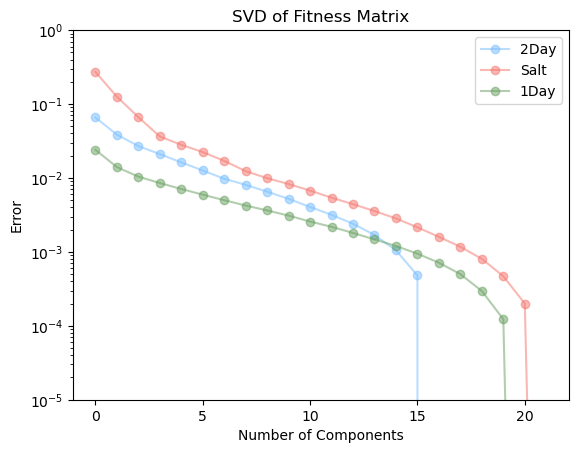

In [43]:
# plot same thing but plot number of components as a function of error (1-variance explained)
error = []
# do SVD on fitness_df
for base in environment_dict.keys():
    X = fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], environment_dict[base]].values
    U, S, V = np.linalg.svd(X, full_matrices=False)
    variance_explained = np.cumsum(S**2/np.sum(S**2))
    print(1-variance_explained)
    plt.semilogy(1-variance_explained, 'o-', color = env_color_dict[base], label = base, alpha=0.5)
plt.ylim(1e-5, 1)
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.title('SVD of Fitness Matrix')
plt.legend()



In [115]:
# full_df =full_df.set_index('barcode')
# Y = full_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], subtle].values
full_df[[cond for cond in subtle if 'EC' in cond]]
# average over all EC conditions as a new column in full_df
full_df['EC_avg'] = full_df[[cond for cond in subtle if 'EC' in cond]].mean(axis=1)


barcode
CGCTAAAGACATAATGTGGTTTGTTG_AACGTAAGTCTAAACGTATTTGAGAA    0.342185
CGCTAAAGACATAATGTGGTTTGTTG_TCCATAATTGGGAATTGGATTTTGGC    1.179204
CGCTAAAGACATAATGTGGTTTGTTG_TTAATAAACAAGAAACGGGTTGTGGA    0.249863
CGCTAAAGACATAATGTGGTTTGTTG_TCACTAAGAAGGAAGTCCATTATTAC    0.891490
CGCTAAAGACATAATGTGGTTTGTTG_AGCCAAAAAAGTAATATTTTTGACCA    0.841647
                                                           ...   
CGCTAAAGACATAATGTGGTTTGTTG_CTTCAAATCCTCAAATTACTTCGCAT    0.303066
CGCTAAAGACATAATGTGGTTTGTTG_GAATCAAACTTTAAGGACGTTTAACG    0.324004
CGCTAAAGACATAATGTGGTTTGTTG_CAAGAAACTTGTAACAGTTTTGAGTT    0.048450
CGCTAAAGACATAATGTGGTTTGTTG_CGCCAAATAATCAAATGTGTTTCGCT    0.303755
CGCTAAAGACATAATGTGGTTTGTTG_CTGTGAATTACGAAAAATGTTACTCC   -0.009786
Name: EC_avg, Length: 409, dtype: float64

In [122]:
perturbation_full_df = full_df[subtle].copy()
for env in subtle:
    perturbation_full_df[env] = full_df[env] - full_df['EC_avg']

perturbation_full_df

Y = perturbation_full_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], subtle].values

['Batch2_2Day_1.5_fitness', 'Batch3_2Day_M3_fitness', 'Batch4_2Day_M3_fitness', 'Batch1_Salt_30_fitness', 'Batch2_Salt_1.5_fitness', 'Batch3_Salt_M3_fitness', 'Batch4_Salt_M3_fitness', 'Batch1_1Day_30_fitness', 'Batch2_1Day_1.5_fitness', 'Batch3_1Day_M3_fitness', 'Batch4_1Day_M3_fitness']
[0.58231402 0.13594586 0.10009568 0.03742235 0.03249231 0.02986154
 0.02130127 0.01655426 0.01080709 0.00989991 0.00690968 0.00592165
 0.00540799 0.0050664 ]
[6.37813459e-01 1.57264341e-01 1.17763957e-01 2.81472138e-02
 1.44480905e-02 1.26601709e-02 7.21418857e-03 6.21395565e-03
 3.95595439e-03 3.54677402e-03 2.68735906e-03 2.08951757e-03
 1.68708046e-03 1.44474173e-03 1.10446459e-03 7.90395506e-04
 6.20950047e-04 5.47386446e-04]
[0.54971283 0.17177932 0.07966418 0.07225382 0.03132551 0.02307149
 0.01364019 0.01124562 0.01009753 0.00698509 0.0066014  0.00519452
 0.00449287 0.00411476 0.0039626  0.00361895 0.00223931]


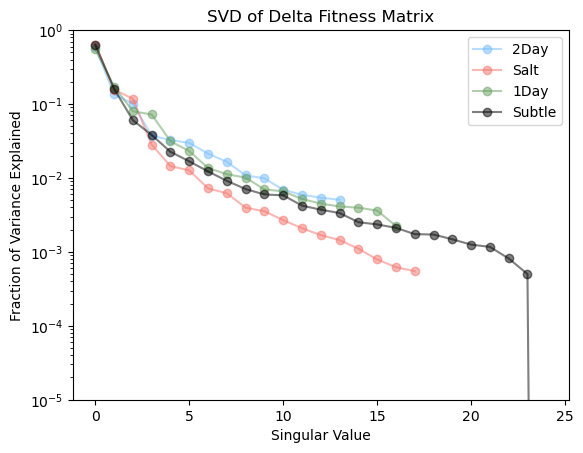

In [124]:
# do SVD on fitness_df
print(all_base_conds)
for base in environment_dict.keys():
    these_conds = [cond for cond in environment_dict[base] if cond not in all_base_conds]
    X = organized_local_perturbation_fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], these_conds].values
    U, S, V = np.linalg.svd(X, full_matrices=False)
    plt.semilogy((S**2/np.sum(S**2)), 'o-', color = env_color_dict[base], label = base, alpha=0.5)
    print(S**2/np.sum(S**2))

u_g, s_g, v_g = np.linalg.svd(Y, full_matrices=False)
plt.semilogy((s_g**2/np.sum(s_g**2)), 'o-', color = 'black', label = 'Subtle', alpha=0.5)

plt.xlabel('Singular Value')
plt.ylabel('Fraction of Variance Explained')
plt.title('SVD of Delta Fitness Matrix')
plt.ylim(1e-5, 1)
plt.legend()

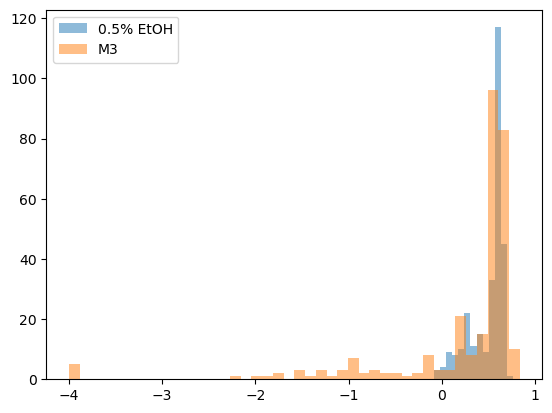

In [134]:
# plt.hist(fitness_df['Batch4_Salt_0.5%EtOH_fitness'].values.flatten(), bins=50, alpha=0.5)
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch4_Salt_0.5%EtOH_fitness'].values.flatten(), bins='auto', alpha=0.5, label='0.5% EtOH')
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch4_Salt_M3_fitness'].values.flatten(), bins='auto', alpha=0.5, label='M3')
plt.legend()

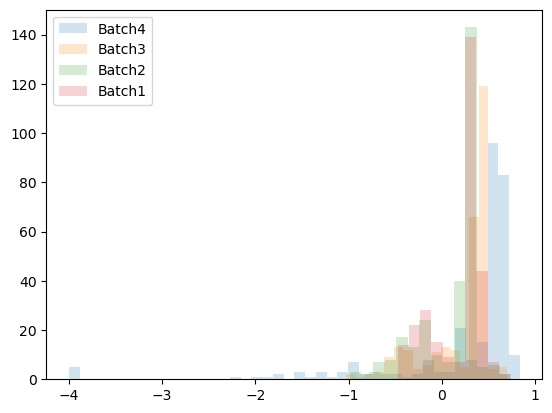

In [137]:
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch4_Salt_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch4')
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch3_Salt_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch3')
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch2_Salt_1.5_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch2')
plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], 'Batch1_Salt_30_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch1')
plt.legend()

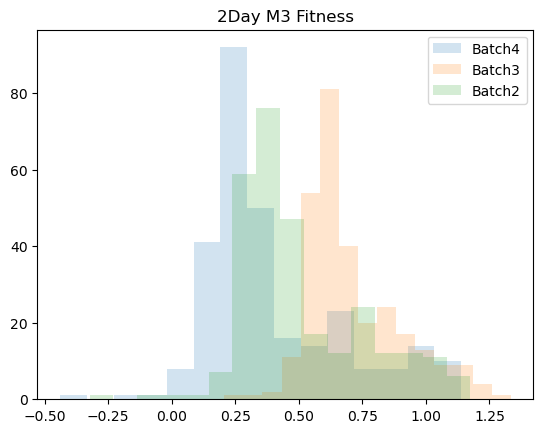

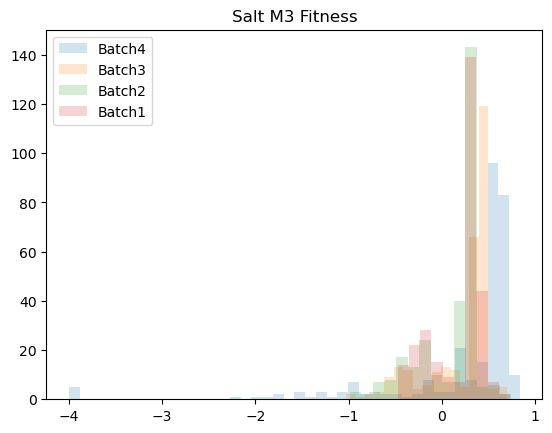

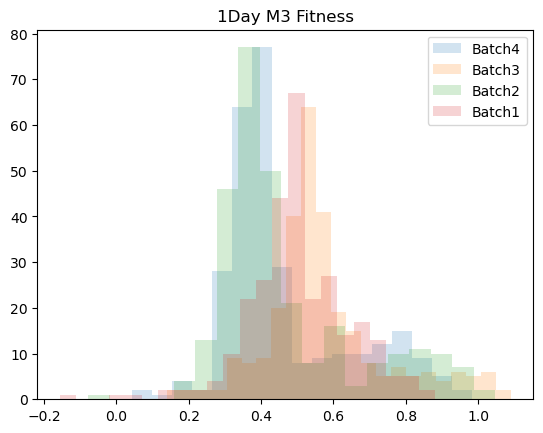

In [139]:
for base in environment_dict.keys():
    if base == '2Day':
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch4_{base}_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch4')
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch3_{base}_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch3')
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch2_{base}_1.5_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch2')
        plt.legend()
        plt.title(f'{base} M3 Fitness')
        plt.show()
        plt.close()
    else:
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch4_{base}_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch4')
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch3_{base}_M3_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch3')
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch2_{base}_1.5_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch2')
        plt.hist(fitness_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], f'Batch1_{base}_30_fitness'].values.flatten(), bins='auto', alpha=0.2, label='Batch1')
        plt.legend()
        plt.title(f'{base} M3 Fitness')
        plt.show()
        plt.close()

[0.64156537 0.16055415 0.05657729 0.03221079 0.02485026 0.02305446
 0.0149928  0.01371765 0.01138521 0.00589107 0.00569745 0.0034483
 0.00324354 0.00281163]
[0.82084931 0.04208215 0.03356408 0.02043504 0.01725738 0.01089168
 0.00908716 0.00877993 0.00750224 0.00632374 0.00529842 0.00410884
 0.00373096 0.00263798 0.00216614 0.00193435 0.00183874 0.00151185]
[0.54507686 0.12883007 0.11455917 0.07132579 0.04089175 0.01994378
 0.01636045 0.01454869 0.00980071 0.00827774 0.00694173 0.00567719
 0.0049212  0.00380456 0.00347891 0.00317235 0.00238906]


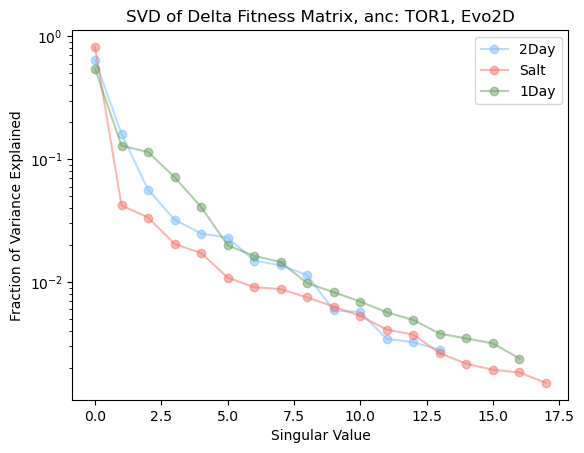

[0.87089029 0.0598134  0.01422035 0.01231801 0.01110885 0.00736308
 0.0070115  0.00491263 0.00319346 0.0028596  0.00233335 0.0014135
 0.00137751 0.00118446]
[8.62672439e-01 7.74451327e-02 1.42433179e-02 8.17062842e-03
 7.73073244e-03 6.70367327e-03 4.28608288e-03 2.87441565e-03
 2.69491644e-03 2.45208061e-03 2.15270190e-03 1.86888761e-03
 1.60281181e-03 1.30928557e-03 1.14379902e-03 1.10623684e-03
 8.53599684e-04 6.89258697e-04]
[0.74203484 0.09478648 0.05889147 0.02712989 0.01834272 0.01342434
 0.00830239 0.00665487 0.00550349 0.00511533 0.00422045 0.00349662
 0.00313098 0.00290673 0.00235611 0.00202068 0.00168261]


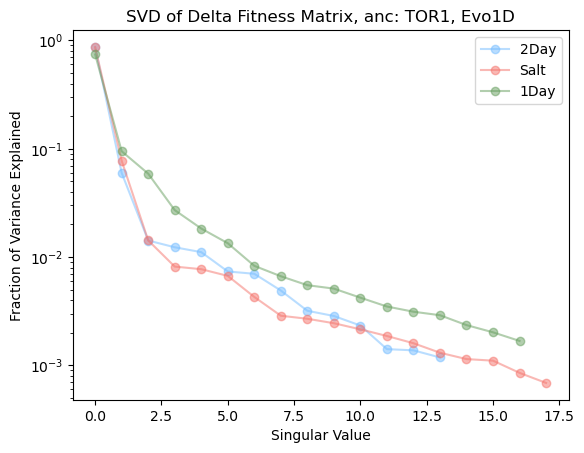

[0.79205072 0.07122565 0.03534155 0.02036677 0.01976078 0.01584009
 0.01134812 0.00855991 0.0068407  0.00594701 0.00411034 0.00326679
 0.00294705 0.00239453]
[0.19869818 0.18158468 0.17069505 0.11019192 0.04726836 0.04267803
 0.03864957 0.03534052 0.03171913 0.03024469 0.02656494 0.01831869
 0.01625154 0.01564388 0.01400284 0.0111002  0.00702933 0.00401846]
[0.55506304 0.1473747  0.08454754 0.05592161 0.04178521 0.02737845
 0.02043514 0.01263186 0.01069251 0.00960091 0.0064139  0.00606359
 0.00543891 0.00470909 0.004595   0.00372342 0.00362511]


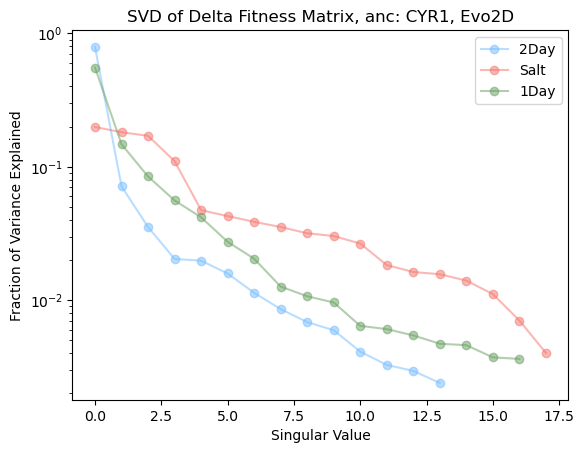

[0.83457718 0.06384274 0.02115127 0.01847314 0.01680304 0.01368855
 0.00785729 0.00545366 0.00488032 0.00436922 0.00300556 0.00220112
 0.00211351 0.00158338]
[0.3087118  0.22194851 0.11195402 0.0713527  0.05536086 0.04875695
 0.04355979 0.02782269 0.02366078 0.02172841 0.01373982 0.0135614
 0.01120131 0.00832621 0.00715573 0.00524864 0.00347681 0.00243357]
[0.66380338 0.1007977  0.08674037 0.03815497 0.02516427 0.01949901
 0.01483432 0.00914276 0.00765009 0.00672299 0.00579674 0.00516965
 0.00424103 0.00380682 0.00318117 0.00280272 0.00249202]


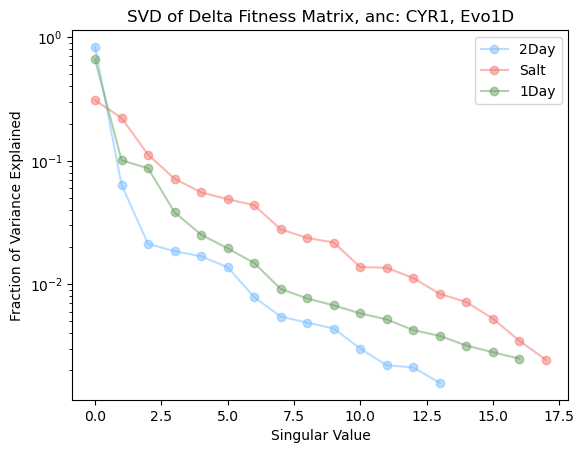

[8.73486143e-01 5.73829303e-02 2.74027368e-02 1.34514591e-02
 7.41620925e-03 5.21848744e-03 4.02320985e-03 3.26653727e-03
 2.04912828e-03 1.82470799e-03 1.48765963e-03 1.22107491e-03
 9.73483954e-04 7.96232728e-04]
[0.65400047 0.12577595 0.06481499 0.03577798 0.02970127 0.01839171
 0.01721806 0.0117372  0.01044191 0.00797738 0.00736569 0.00606534
 0.00315495 0.00223137 0.00179492 0.00149247 0.00118504 0.00087331]
[0.72587349 0.0810738  0.04741524 0.04329738 0.02488289 0.019086
 0.01195346 0.01100075 0.00823079 0.00553609 0.00456382 0.00429739
 0.00357955 0.00304911 0.00263288 0.00201345 0.0015139 ]


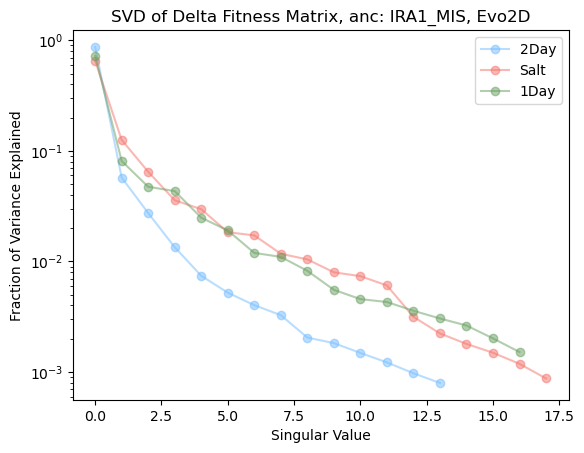

[0.82426305 0.07265835 0.02383123 0.02253491 0.01711486 0.01103087
 0.00632806 0.00533294 0.0037189  0.00366748 0.00308105 0.0028069
 0.001959   0.0016724 ]
[0.76690124 0.07196523 0.05774016 0.02429238 0.01546206 0.01471475
 0.011005   0.00921209 0.00706792 0.00588044 0.00496427 0.00280043
 0.00168784 0.00158553 0.00134733 0.00122767 0.00110336 0.00104232]
[0.75774346 0.07717827 0.06344113 0.03150827 0.01808896 0.01274053
 0.00865247 0.00603859 0.00464014 0.00389615 0.00354877 0.0027335
 0.0025704  0.00224198 0.00187355 0.00170424 0.00139958]


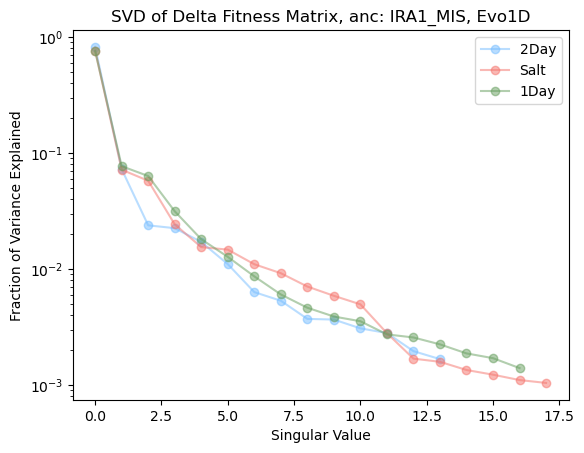

[8.99511100e-01 4.03240437e-02 2.06362014e-02 1.46505537e-02
 9.11933511e-03 3.52398580e-03 3.14399531e-03 2.31730544e-03
 1.98646558e-03 1.48323856e-03 1.09765623e-03 9.21290940e-04
 6.98163660e-04 5.86664092e-04]
[0.2482748  0.18218062 0.13099411 0.10469008 0.05549527 0.05014417
 0.03662509 0.03396977 0.02887511 0.0257245  0.02256962 0.02179822
 0.01791549 0.01314195 0.01242286 0.0098231  0.00347107 0.00188415]
[0.75318626 0.06816085 0.04205571 0.03761205 0.02566307 0.01835443
 0.01117936 0.00883109 0.0076054  0.00617904 0.00504846 0.00377621
 0.00347725 0.00300385 0.00278884 0.00166852 0.0014096 ]


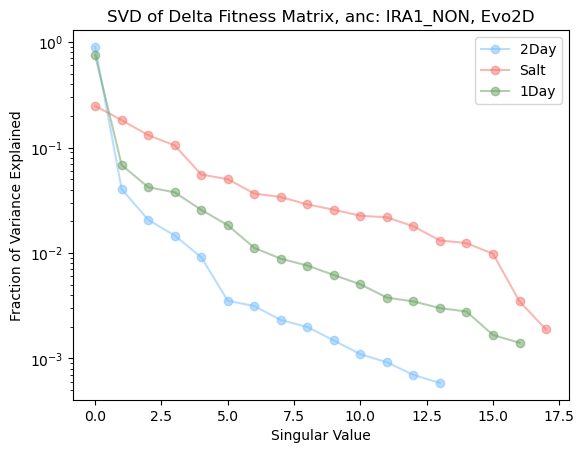

[9.71846829e-01 1.33272985e-02 6.54108148e-03 2.74040075e-03
 1.87559365e-03 1.36771480e-03 1.06613571e-03 5.06163562e-04
 3.16409344e-04 2.74703952e-04 8.34974487e-05 5.41719868e-05]
[0.36661032 0.22085031 0.15332427 0.08925542 0.05825061 0.03454774
 0.02493693 0.02122944 0.01763413 0.0066423  0.00451322 0.0022053 ]
[8.96514320e-01 3.19453874e-02 2.69730892e-02 1.76070076e-02
 1.31219347e-02 4.56084662e-03 3.86062348e-03 2.14877522e-03
 1.51198476e-03 9.96943339e-04 6.81021412e-04 7.80660249e-05]


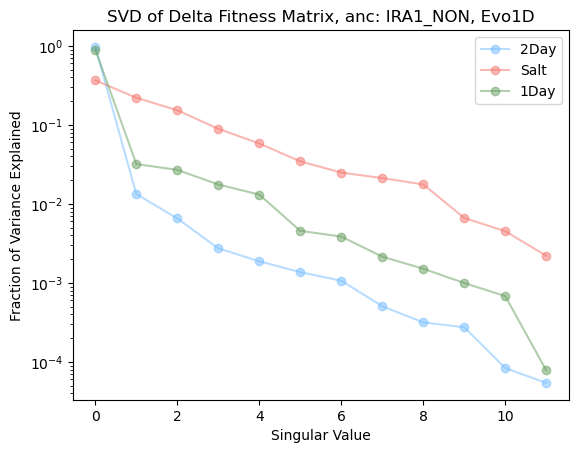

[0.47670632 0.17993705 0.10332453 0.05519167 0.04597329 0.03543696
 0.02193128 0.01744994 0.01505299 0.01370523 0.0120004  0.00941027
 0.0081193  0.00576077]
[0.61666167 0.14582771 0.11426203 0.05341372 0.01437553 0.01359764
 0.00989614 0.00705053 0.0051436  0.00431245 0.00332219 0.00299861
 0.00231821 0.00191864 0.00167004 0.00132926 0.00098902 0.000913  ]
[0.54923846 0.17113124 0.08272346 0.05959251 0.0460058  0.02885608
 0.02678682 0.0095909  0.00579866 0.00409059 0.00343368 0.00302565
 0.00258944 0.00240384 0.00192256 0.00175014 0.00106017]


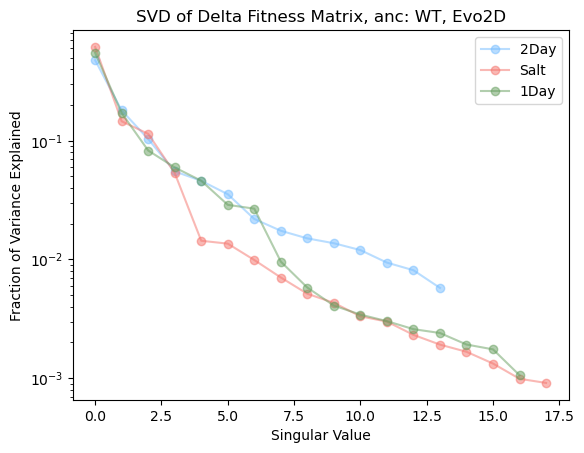

[0.64437765 0.14652688 0.06534301 0.0336702  0.02682957 0.02071468
 0.01733238 0.01649635 0.00794846 0.00628196 0.00457049 0.00383943
 0.00341002 0.00265892]
[0.3132618  0.17219027 0.12091252 0.08068269 0.07370288 0.05081727
 0.04014371 0.03595264 0.02582567 0.01806233 0.01453648 0.01290438
 0.01166701 0.01040281 0.00685186 0.00500572 0.00410191 0.00297805]
[5.65648053e-01 2.06251642e-01 1.00443920e-01 6.24250444e-02
 3.18431521e-02 1.59762427e-02 6.50481470e-03 2.96298610e-03
 1.91222871e-03 1.46835258e-03 1.02129405e-03 9.47942633e-04
 6.85048084e-04 6.39471744e-04 5.25527033e-04 4.23829776e-04
 3.20450485e-04]


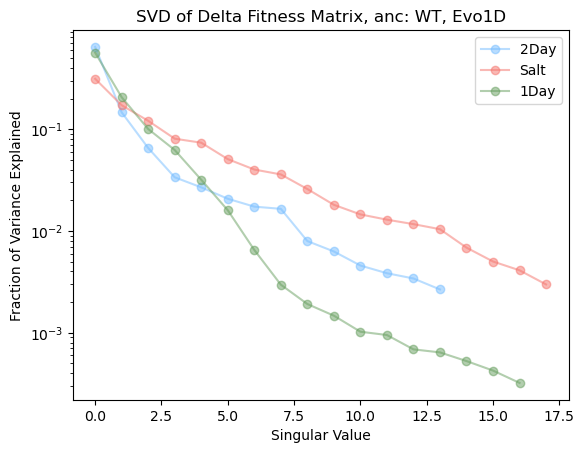

[]
[]
[]


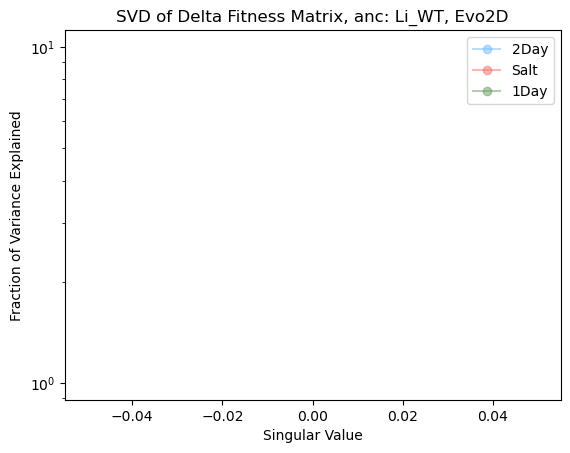

[0.64437765 0.14652688 0.06534301 0.0336702  0.02682957 0.02071468
 0.01733238 0.01649635 0.00794846 0.00628196 0.00457049 0.00383943
 0.00341002 0.00265892]
[0.3132618  0.17219027 0.12091252 0.08068269 0.07370288 0.05081727
 0.04014371 0.03595264 0.02582567 0.01806233 0.01453648 0.01290438
 0.01166701 0.01040281 0.00685186 0.00500572 0.00410191 0.00297805]
[5.65648053e-01 2.06251642e-01 1.00443920e-01 6.24250444e-02
 3.18431521e-02 1.59762427e-02 6.50481470e-03 2.96298610e-03
 1.91222871e-03 1.46835258e-03 1.02129405e-03 9.47942633e-04
 6.85048084e-04 6.39471744e-04 5.25527033e-04 4.23829776e-04
 3.20450485e-04]


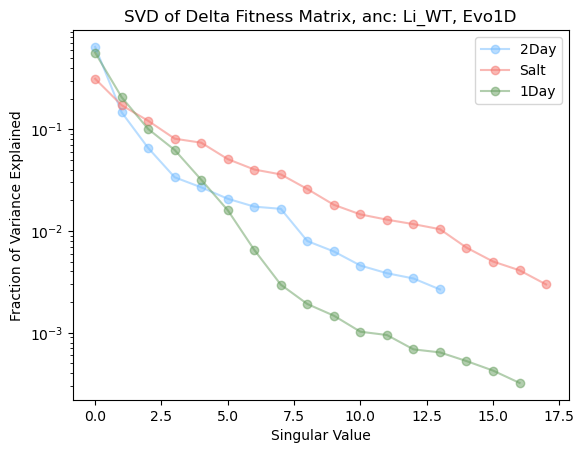

[0.83558166 0.05229726 0.02666495 0.01833531 0.01619267 0.0115885
 0.01076614 0.00807508 0.00718803 0.00355031 0.00308204 0.00245624
 0.00237118 0.00185062]
[0.75671973 0.07040898 0.05104373 0.01954895 0.01699722 0.0141305
 0.01192621 0.0108475  0.01055431 0.00842759 0.00752294 0.0043979
 0.00401337 0.00323929 0.00313787 0.00257786 0.00251387 0.00199218]
[0.57015924 0.22860082 0.06425742 0.03508547 0.02705797 0.01532359
 0.01130982 0.008513   0.00712332 0.00519719 0.00489299 0.00460416
 0.00439607 0.00384691 0.00354673 0.00314209 0.00294324]


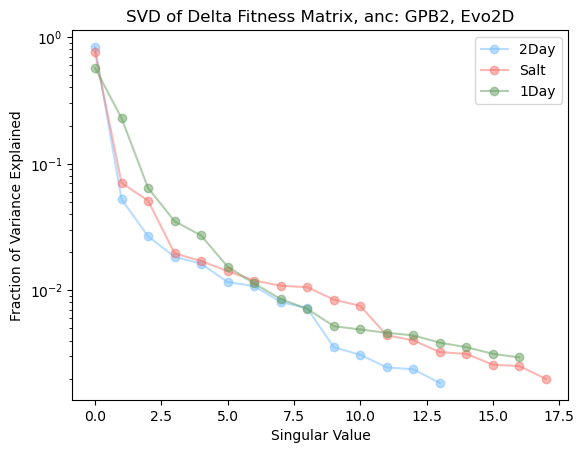

[0.87548372 0.0434143  0.02375911 0.01664593 0.01232909 0.00679519
 0.00572317 0.00391124 0.00323116 0.00253815 0.0017756  0.00163237
 0.00142891 0.00133204]
[0.85020802 0.04266703 0.03011002 0.01725776 0.00949546 0.00890986
 0.00730726 0.00652296 0.00588345 0.00464866 0.00361256 0.00272877
 0.0024079  0.00213842 0.00187191 0.00165268 0.00150466 0.00107263]
[0.7385722  0.08208784 0.06580006 0.03128974 0.0213886  0.01373715
 0.00864688 0.00804609 0.00630452 0.00473763 0.00410983 0.00338687
 0.00300892 0.00282015 0.00248355 0.00195419 0.00162579]


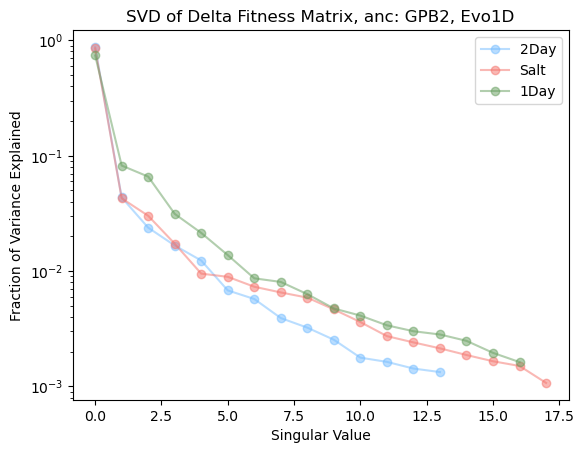

In [100]:
# evolution_condition = 'Evo2D'

for ancestor in ['anc: TOR1', 'anc: CYR1', 'anc: IRA1_MIS', 'anc: IRA1_NON', 'anc: WT', 'anc: Li_WT', 'anc: GPB2', ]:
    for evolution_condition in ['Evo2D', 'Evo1D']:
        mutant_list = mutant_dict[ancestor]
        mutant_list = [mut for mut in mutant_list if mut in mutant_dict[evolution_condition]]
        for base in environment_dict.keys():
            these_conds = [cond for cond in environment_dict[base] if cond not in all_base_conds]
            X = organized_local_perturbation_fitness_df.loc[mutant_list, these_conds].values
            U, S, V = np.linalg.svd(X, full_matrices=False)
            plt.semilogy((S**2/np.sum(S**2)), 'o-', color = env_color_dict[base], label = base, alpha=0.5)
            print(S**2/np.sum(S**2))
        plt.xlabel('Singular Value')
        plt.ylabel('Fraction of Variance Explained')
        plt.title(f'SVD of Delta Fitness Matrix, {ancestor}, {evolution_condition}')
        plt.legend()
        plt.show()
        plt.close()


[0.12049684 0.11306371 0.09362525 0.08916077 0.08148301 0.07210385
 0.06787173 0.06438557 0.05890801 0.0579151  0.05390319 0.04974496
 0.04097585 0.03636217]
[0.89303284 0.01770468 0.01508971 0.01145474 0.00900493 0.00721007
 0.00610419 0.00599193 0.00564539 0.0050214  0.00425826 0.00394176
 0.0036157  0.00300541 0.00273363 0.00233003 0.00209972 0.0017556 ]
[0.16919736 0.11716191 0.10084637 0.08774138 0.06718643 0.06399459
 0.0598469  0.05149778 0.04347008 0.04036196 0.03855775 0.03829318
 0.03230105 0.02602775 0.02374009 0.02316152 0.0166139 ]


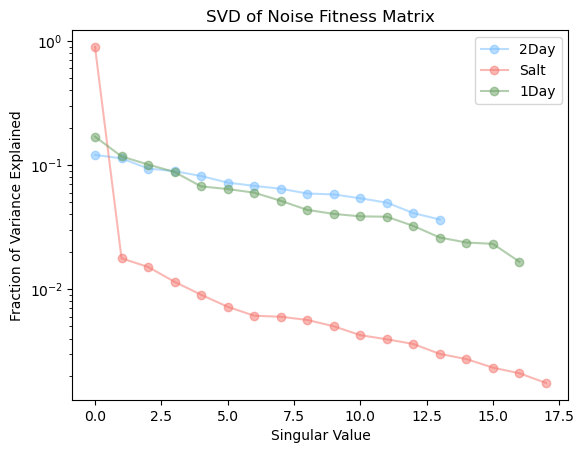

In [96]:
replicate_difference_fitness_df = pd.DataFrame(index = fitness_df.index)

for condition in all_conds:
    r1 = condition.replace('_fitness', '-R1_fitness')
    r2 = condition.replace('_fitness', '-R2_fitness')
    replicate_difference_fitness_df[condition] = fitness_df[r1] - fitness_df[r2]

# make noise only matrix by taking standard error and making a gaussian random variance mean 0, std = std error
noise_only_df = pd.DataFrame(index = fitness_df.index)
for condition in all_conds:
    errors = fitness_df[condition.replace('_fitness', '_stderror')]
    noise = np.random.normal(0, errors)
    noise_only_df[condition] = noise

for base in environment_dict.keys():
    these_conds = [cond for cond in environment_dict[base] if cond not in all_base_conds]
    X = noise_only_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], these_conds].values
    U, S, V = np.linalg.svd(X, full_matrices=False)
    plt.semilogy((S**2/np.sum(S**2)), 'o-', color = env_color_dict[base], label = base, alpha=0.5)
    print(S**2/np.sum(S**2))
plt.xlabel('Singular Value')
plt.ylabel('Fraction of Variance Explained')
plt.title('SVD of Noise Fitness Matrix')
plt.legend()

    

In [58]:
# how do we think about error here? 
# what does this delta matrix look like if we only subtracted replicates from one another? 
delta_replicate_df = pd.DataFrame(index = fitness_df.index)
for cond in all_conds:
    # get rid of fitness from title
    r1_cond = cond.replace('_fitness', '-R1_fitness')
    r2_cond = cond.replace('_fitness', '-R2_fitness')
    difference = fitness_df[r1_cond] - fitness_df[r2_cond]
    delta_replicate_df[cond] = difference

    


[0.25385623 0.15686246 0.10778162 0.08792255 0.07182711 0.05920704
 0.05165969 0.04763636 0.03603978 0.0314432  0.02362835 0.01830814
 0.0154032  0.01163111 0.01011028 0.00932594 0.00735694]
[0.35980777 0.17632285 0.09771834 0.08888629 0.05943679 0.04904887
 0.0372605  0.03263029 0.02304723 0.01589316 0.01247139 0.01077775
 0.00863173 0.00650679 0.00472789 0.00383002 0.00347472 0.00269465
 0.00229201 0.00173698 0.00153653 0.00126748]
[0.41335214 0.16068478 0.14619269 0.09118282 0.0331188  0.02407005
 0.01894883 0.01575312 0.0145769  0.01171696 0.00984589 0.00907594
 0.00809194 0.00737118 0.00688836 0.00627767 0.00562127 0.00509781
 0.00454477 0.0042008  0.0033873 ]


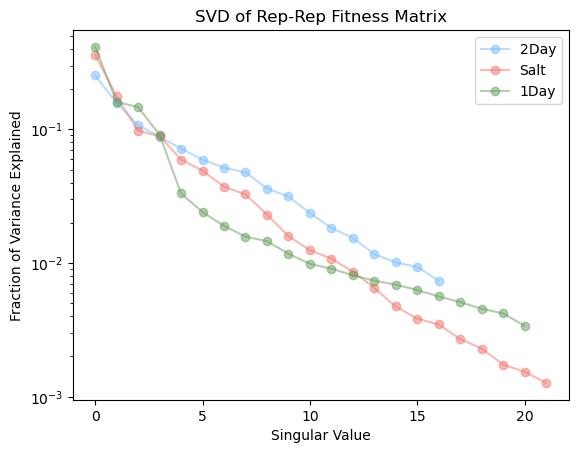

In [62]:
# do SVD on fitness_df
for base in environment_dict.keys():
    X = delta_replicate_df.loc[mutant_dict['Original Testing']+mutant_dict['Original Training'], environment_dict[base]].values
    U, S, V = np.linalg.svd(X, full_matrices=False)
    plt.semilogy((S**2/np.sum(S**2)), 'o-', color = env_color_dict[base], label = base, alpha=0.5)
    print(S**2/np.sum(S**2))
plt.xlabel('Singular Value')
plt.ylabel('Fraction of Variance Explained')
plt.title('SVD of Rep-Rep Fitness Matrix')
plt.legend()



In [66]:
print(fitness_df.columns)

Index(['Batch1_1Day_28-R1_fitness', 'Batch1_1Day_28-R1_stderror',
       'Batch1_1Day_28-R2_fitness', 'Batch1_1Day_28-R2_stderror',
       'Batch1_1Day_30-R1_fitness', 'Batch1_1Day_30-R1_stderror',
       'Batch1_1Day_30-R2_fitness', 'Batch1_1Day_30-R2_stderror',
       'Batch1_1Day_30Baffle-R1_fitness', 'Batch1_1Day_30Baffle-R1_stderror',
       ...
       'Batch2_Salt_1.8Baffle_stderror', 'Batch4_1Day_M3_fitness',
       'Batch4_1Day_M3_stderror', 'Batch4_1Day_0.5%EtOH_fitness',
       'Batch4_1Day_0.5%EtOH_stderror', 'Batch4_2Day_M3_fitness',
       'Batch4_2Day_M3_stderror', 'Batch1_1Day_30_fitness',
       'Batch1_1Day_30_stderror', 'barcode'],
      dtype='object', length=361)


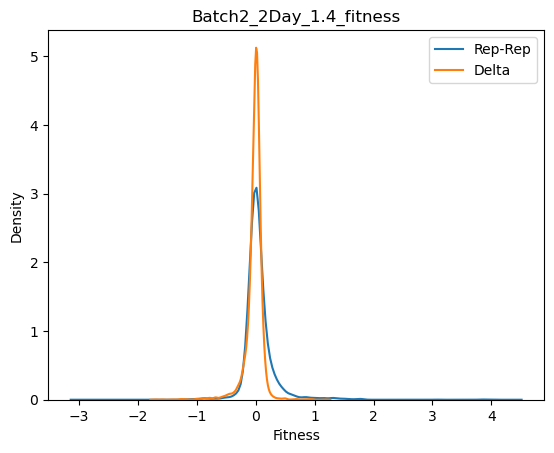

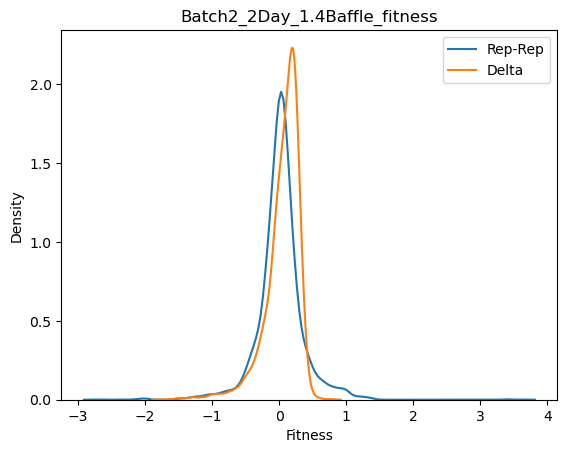

In [81]:
# plot a histogram of fitness values for each condition
for cond in all_conds[:2]: 
    fig, ax = plt.subplots()

    # sns.histplot(fitness_df[cond], ax=ax, label='Fitness')
    # sns.histplot(delta_replicate_df[cond], ax=ax, label='Rep-Rep', kde=True)
    # sns.histplot(organized_local_perturbation_fitness_df[cond], ax=ax, label='Delta', kde=True)
    # normalize histograms to be pdfs
    # sns.kdeplot(fitness_df[cond], ax=ax, label='Fitness')
    sns.kdeplot(data = delta_replicate_df, x=cond, ax=ax, label='Rep-Rep', common_norm=False)
    sns.kdeplot(data = organized_local_perturbation_fitness_df, x = cond, ax=ax, label='Delta', common_norm=False)

    # plot a 0 centered gaussian with same variacne as rep-rep data
    # mean = np.mean(delta_replicate_df[cond])
    # std = np.std(delta_replicate_df[cond])
    # x = np.linspace(mean-4*std, mean+4*std, 100)
    # y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    # ax.plot(x, y, label='Rep-Rep Gaussian', color='red')
    
    plt.xlabel('Fitness')
    plt.ylabel('Density')
    plt.title(f'{cond}')
    plt.legend()
    plt.show()
    plt.close()

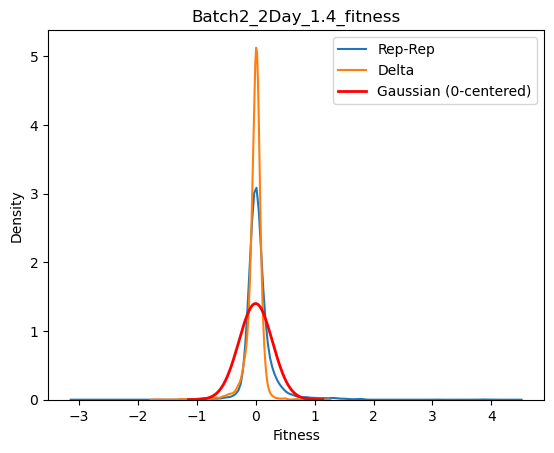

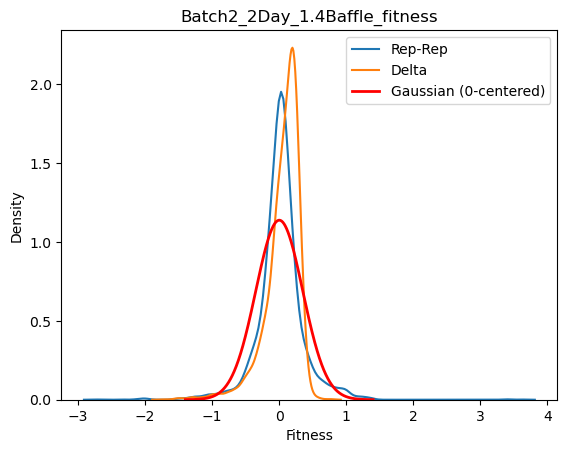

In [85]:
for cond in all_conds[:2]: 
    fig, ax = plt.subplots()

    # Plot KDEs with common normalization disabled
    sns.kdeplot(data=delta_replicate_df, x=cond, ax=ax, label='Rep-Rep', common_norm=False)
    sns.kdeplot(data=organized_local_perturbation_fitness_df, x=cond, ax=ax, label='Delta', common_norm=False)

    # Gaussian plotting code
    std = np.std(delta_replicate_df[cond])
    x = np.linspace(-4*std, 4*std, 1000)
    gaussian = norm.pdf(x, 0, std)
    ax.plot(x, gaussian, label='Gaussian (0-centered)', color='red', lw=2)

    plt.xlabel('Fitness')
    plt.ylabel('Density')
    plt.title(f'{cond}')
    plt.legend()
    plt.show()
    plt.close()




In [89]:
for cond in twoday_conds:
   all_predictions,
   print(organized_local_perturbation_fitness_df[cond])

TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA   -0.059010
CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT   -0.069662
GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT   -0.058426
CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT   -0.055841
TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG   -0.000750
                                                           ...   
TTAAAAATACAAAAAAAGATTTAAGG_GATCCGATATCGGTACCGTTTCAAAA    0.012705
TTAAAAATACAAAAAAAGATTTAAGG_TCCGATATCGGTACCATCGTTTTCTT    0.029060
ATCAGAAGTTCGAATCAAATTACGAA_TCGGTACTACAAAAATGATTTGGGGC   -0.122983
TTAAAAATACAAAAAAAGATTTAAGG_TCTACAAATCTAAGTATTGTACA       0.023767
TTAAAAATACAAAAAAAGATTTAAGG_TCTTTAAAGCAGTTAAACA          -0.423539
Name: Batch2_2Day_1.4_fitness, Length: 4816, dtype: float64
TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA   -0.025314
CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT    0.279279
GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT    0.109693
CCAACAAAACACAAAT